# Data analysis

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [15]:
last = pd.read_csv("data/last.txt", sep=";")
last["shape"] = last["shape"].apply(lambda x: x.split("-")[0])
last["controller"] = last["controller"].apply(lambda x: x.replace("LIF", "SNN"))
last["sensor.config"] = last["sensor.config"].apply(lambda x: x.split("-")[0].replace("spinedTouchSighted", "rich"))
last["step"] = last["step"].apply(lambda x: "step" if x == "T" else "no-step")
last["$f_c$"] = last["step"].apply(lambda x: "$4Hz$" if x == "step" else "$60Hz$")
last.head()

,experiment.name,seed,terrain,shape,sensor.config,mapper,transformation,solver,episode.time,episode.transient.time,...,best.fitness.footprints.spectra..27.,best.fitness.footprints.spectra..28.,best.fitness.footprints.spectra..29.,best.fitness.footprints.spectra..30.,best.fitness.footprints.spectra..31.,best.solution.serialized,architecture,step,controller,$f_c$
0,snn-centralized,0,flat,biped,rich,brainCentralized<qSnnConv;nIL=1;r=1;stv=avg_me...,identity,ES;nPop=36;nEval=20000,30,5,...,34.805719,20.769799,12.168933,8.184847,8.464860,H4sIAAAAAAAA/+yda4+l13Gd/0t/bg32/cJPESQZECBRjq...,Centralized,no-step,SNN,$60Hz$
1,snn-centralized,0,flat,biped,rich,brainCentralized<qSnnConv;nIL=1;r=1;stv=avg_me...,identity,ES;nPop=36;nEval=20000,30,5,...,24.878136,24.908329,15.143474,14.780565,12.787218,H4sIAAAAAAAA/+ydfW+t13Hdvwv/poj9/qK/atgOasCWW0...,Centralized,no-step,SNN-H,$60Hz$
2,snn-centralized,0,flat,biped,rich,brainCentralized<mlp;nIL=1;r=1,identity,ES;nPop=36;nEval=20000,30,5,...,35.637301,24.737519,16.411284,8.447346,5.256231,H4sIAAAAAAAA/+yda49m1XGF/0t/7mnt+4VPQQYrSARbgC...,Centralized,no-step,MLP,$60Hz$
3,snn-centralized,0,flat,biped,touch,brainCentralized<qSnnConv;nIL=1;r=1;stv=avg_me...,identity,ES;nPop=36;nEval=20000,30,5,...,33.362417,16.838530,10.919022,10.968093,13.247009,H4sIAAAAAAAA/+yZSW8bNxSA/8ucJwPui041vAAGbDm11K...,Centralized,no-step,SNN,$60Hz$
4,snn-centralized,0,flat,biped,touch,brainCentralized<qSnnConv;nIL=1;r=1;stv=avg_me...,identity,ES;nPop=36;nEval=20000,30,5,...,22.230475,25.129133,18.676639,14.849033,9.218062,H4sIAAAAAAAA/+xaW08bORT+L/M8jHy/5GkRUC0ShS5k25...,Centralized,no-step,SNN-H,$60Hz$


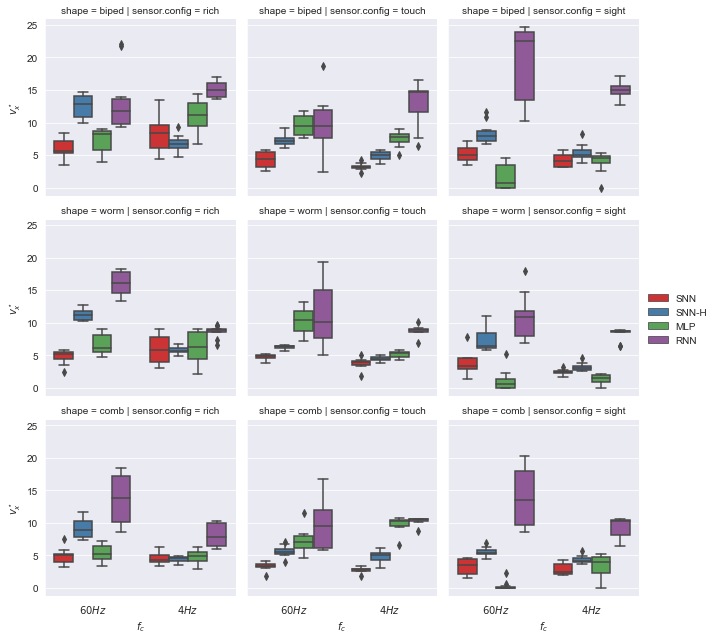

In [16]:
g = sns.FacetGrid(last, col="sensor.config", row="shape")
g.map_dataframe(sns.boxplot, x="$f_c$", y="best.fitness.fitness", hue="controller", palette="Set1")
g.add_legend()
g.set_ylabels("$v_x^\star$")
plt.show()

In [17]:
alpha = 0.05 / 16

shapes = last["shape"].unique()
sensors = last["sensor.config"].unique()
steps = last["step"].unique()
controllers = last["controller"].unique()

p_list = []

for c1 in controllers:
  for c2 in controllers:
    counter = 0
    if c1 != c2:
      for shape in shapes:
        for sensor in sensors:
          for step in steps:
            v1 = last[(last["shape"] == shape) & (last["sensor.config"] == sensor) & (last["step"] == step) & (
                last["controller"] == c1)]["best.fitness.fitness"].to_list()
            v2 = last[(last["shape"] == shape) & (last["sensor.config"] == sensor) & (last["step"] == step) & (
                last["controller"] == c2)]["best.fitness.fitness"].to_list()
            if mannwhitneyu(v1, v2, alternative="greater").pvalue < alpha:
              counter += 1
    p_list.append({"c1": c1, "c2": c2, "n": counter})

p_df = pd.DataFrame.from_dict(p_list)
p_df = p_df.pivot(index="c1", columns=["c2"], values="n")
p_df = p_df[["MLP", "RNN", "SNN", "SNN-H"]]
p_df = p_df.reindex(["MLP", "RNN", "SNN", "SNN-H"])
p_df["total"] = p_df["MLP"] + p_df["RNN"] + p_df["SNN"] + p_df["SNN-H"]
p_df

c2,MLP,RNN,SNN,SNN-H,total
c1,,,,,
MLP,0,0,6,5,11
RNN,12,0,17,14,43
SNN,4,0,0,0,4
SNN-H,7,0,13,0,20


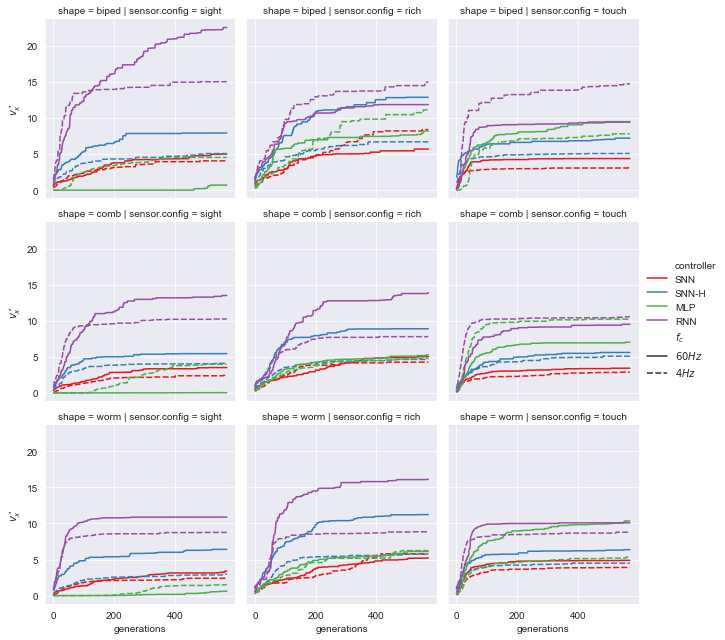

In [18]:
best = pd.read_csv("data/best-evo.txt", sep=";")
best["controller"] = best["controller"].apply(lambda x: x.replace("LIF", "SNN"))
best["shape"] = best["shape"].apply(lambda x: x.split("-")[0])
best["sensor.config"] = best["sensor.config"].apply(lambda x: x.split("-")[0].replace("spinedTouchSighted", "rich"))
best["step"] = best["step"].apply(lambda x: "step" if x == "T" else "no-step")
best["$f_c$"] = best["step"].apply(lambda x: "$4Hz$" if x == "step" else "$60Hz$")

g = sns.FacetGrid(best, col="sensor.config", row="shape")
g.map_dataframe(sns.lineplot, x="iterations", y="median", hue="controller", palette="Set1", style="$f_c$")
g.add_legend()
g.set_xlabels("generations")
g.set_ylabels("$v_x^\star$")
plt.show()

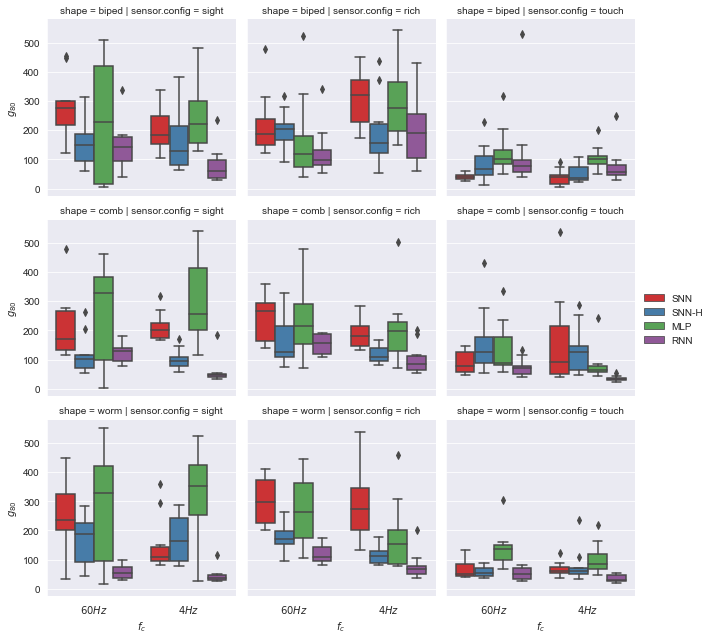

In [19]:
efficiency = pd.read_csv("data/eff-80.txt", sep=";")
efficiency["controller"] = efficiency["controller"].apply(lambda x: x.replace("LIF", "SNN"))
efficiency["shape"] = efficiency["shape"].apply(lambda x: x.split("-")[0])
efficiency["sensor.config"] = efficiency["sensor.config"].apply(
  lambda x: x.split("-")[0].replace("spinedTouchSighted", "rich"))
efficiency["step"] = efficiency["step"].apply(lambda x: "step" if x == "T" else "no-step")
efficiency["$f_c$"] = efficiency["step"].apply(lambda x: "$4Hz$" if x == "step" else "$60Hz$")

g = sns.FacetGrid(efficiency, col="sensor.config", row="shape")
g.map_dataframe(sns.boxplot, x="$f_c$", y="iterations", hue="controller", palette="Set1")
g.add_legend()
g.set_ylabels("$g_{80}$")
plt.show()

In [20]:
alpha = 0.05 / 16

shapes = efficiency["shape"].unique()
sensors = efficiency["sensor.config"].unique()
steps = efficiency["step"].unique()
controllers = efficiency["controller"].unique()

p_list = []

for c1 in controllers:
  for c2 in controllers:
    counter = 0
    if c1 != c2:
      for shape in shapes:
        for sensor in sensors:
          for step in steps:
            v1 = efficiency[(efficiency["shape"] == shape) & (efficiency["sensor.config"] == sensor) & (
                efficiency["step"] == step) & (efficiency["controller"] == c1)]["iterations"].to_list()
            v2 = efficiency[(efficiency["shape"] == shape) & (efficiency["sensor.config"] == sensor) & (
                efficiency["step"] == step) & (efficiency["controller"] == c2)]["iterations"].to_list()
            if mannwhitneyu(v1, v2, alternative="less").pvalue < alpha:
              counter += 1
    p_list.append({"c1": c1, "c2": c2, "n": counter})

p_df = pd.DataFrame.from_dict(p_list)
p_df = p_df.pivot(index="c1", columns=["c2"], values="n")
p_df = p_df[["MLP", "RNN", "SNN", "SNN-H"]]
p_df = p_df.reindex(["MLP", "RNN", "SNN", "SNN-H"])
p_df["total"] = p_df["MLP"] + p_df["RNN"] + p_df["SNN"] + p_df["SNN-H"]
p_df

c2,MLP,RNN,SNN,SNN-H,total
c1,,,,,
MLP,0,0,0,0,0
RNN,7,0,9,5,21
SNN,3,1,0,0,4
SNN-H,3,0,4,0,7


In [21]:
rho = pd.read_csv("data/validation.txt", sep=";")
rho["controller"] = rho["controller"].apply(lambda x: x.replace("LIF", "SNN"))
rho["shape"] = rho["shape"].apply(lambda x: x.split("-")[0])
rho["sensor.config"] = rho["sensor.config"].apply(lambda x: x.split("-")[0].replace("spinedTouchSighted", "rich"))
rho["step"] = rho["step"].apply(lambda x: "step" if x == "T" else "no-step")
rho["$f_c$"] = rho["step"].apply(lambda x: "$4Hz$" if x == "step" else "$60Hz$")
rho = rho.groupby(["seed", "controller", "sensor.config", "shape", "step"])[
  "validation.outcome.velocity"].mean().reset_index()
rho = pd.merge(rho, last[["seed", "controller", "sensor.config", "shape", "step", "best.fitness.fitness", "$f_c$"]])
rho["rho"] = rho["validation.outcome.velocity"] / rho["best.fitness.fitness"]
rho.head()

,seed,controller,sensor.config,shape,step,validation.outcome.velocity,best.fitness.fitness,$f_c$,rho
0,0,MLP,rich,biped,no-step,3.480781,9.012577,$60Hz$,0.386214
1,0,MLP,rich,biped,step,4.223114,6.729881,$4Hz$,0.627517
2,0,MLP,rich,comb,no-step,2.554731,7.152697,$60Hz$,0.357170
3,0,MLP,rich,comb,step,1.542768,6.195466,$4Hz$,0.249016
4,0,MLP,rich,worm,no-step,1.766143,4.800911,$60Hz$,0.367877


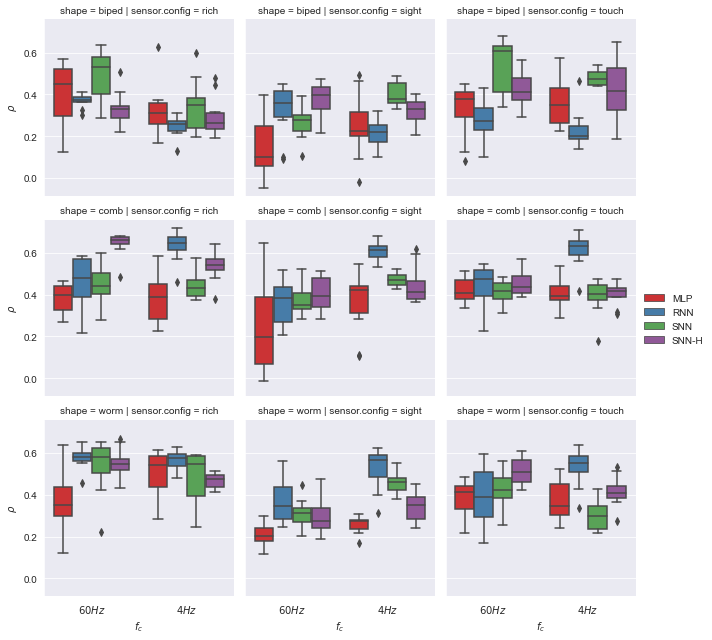

In [22]:
g = sns.FacetGrid(rho, col="sensor.config", row="shape")
g.map_dataframe(sns.boxplot, x="$f_c$", y="rho", hue="controller", palette="Set1")
g.add_legend()
g.set_ylabels("$\\rho$")
plt.show()

In [23]:
alpha = 0.05 / 16

shapes = rho["shape"].unique()
sensors = rho["sensor.config"].unique()
steps = rho["step"].unique()
controllers = rho["controller"].unique()

p_list = []

for c1 in controllers:
  for c2 in controllers:
    counter = 0
    if c1 != c2:
      for shape in shapes:
        for sensor in sensors:
          for step in steps:
            v1 = rho[(rho["shape"] == shape) & (rho["sensor.config"] == sensor) & (rho["step"] == step) & (
                rho["controller"] == c1)]["rho"].to_list()
            v2 = rho[(rho["shape"] == shape) & (rho["sensor.config"] == sensor) & (rho["step"] == step) & (
                rho["controller"] == c2)]["rho"].to_list()
            if mannwhitneyu(v1, v2, alternative="greater").pvalue < alpha:
              counter += 1
    p_list.append({"c1": c1, "c2": c2, "n": counter})

p_df = pd.DataFrame.from_dict(p_list)
p_df = p_df.pivot(index="c1", columns=["c2"], values="n")
p_df = p_df[["MLP", "RNN", "SNN", "SNN-H"]]
p_df = p_df.reindex(["MLP", "RNN", "SNN", "SNN-H"])
p_df["total"] = p_df["MLP"] + p_df["RNN"] + p_df["SNN"] + p_df["SNN-H"]
p_df

c2,MLP,RNN,SNN,SNN-H,total
c1,,,,,
MLP,0,0,0,0,0
RNN,7,0,4,4,15
SNN,2,3,0,2,7
SNN-H,4,4,2,0,10


In [24]:
pca = PCA(n_components=2)
spectrum_columns = [c for c in last.columns if c.startswith("best.fitness.center.")]
dfs = []

for shape in last["shape"].unique():
  tmp = last[last["shape"] == shape].copy()
  x = tmp.loc[:, spectrum_columns].values
  x = StandardScaler().fit_transform(x)
  pc = pca.fit_transform(x)
  print(f"{shape}: {sum(r for r in pca.explained_variance_ratio_):.2f} variance captured")
  tmp["pc1"] = pc[:, 0]
  tmp["pc2"] = pc[:, 1]
  dfs.append(tmp)

last_extra = pd.concat(dfs, ignore_index=True)

biped: 0.61 variance captured
worm: 0.58 variance captured
comb: 0.49 variance captured


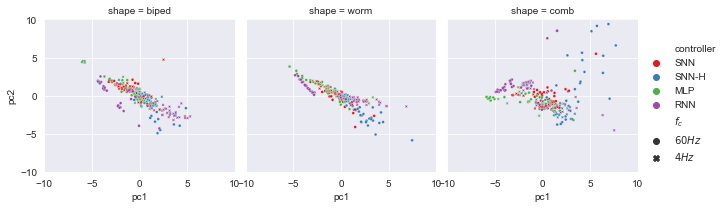

In [25]:
g = sns.FacetGrid(last_extra, col="shape")
g.map_dataframe(sns.scatterplot, x="pc1", y="pc2", hue="controller", style="$f_c$", s=8, palette="Set1")
g.set(xlim=(-10, 10), ylim=(-10, 10))
g.add_legend()
plt.show()

In [55]:
keys = ["shape", "controller", "sensor.config", "$f_c$", "seed"]
values = [
  ["biped", "RNN", "rich", "$60Hz$", 5, "A"],
  ["biped", "RNN", "rich", "$4Hz$", 1, "B"],
  ["biped", "SNN", "touch", "$60Hz$", 8, "C"],
  ["biped", "SNN-H", "sight", "$60Hz$", 8, "D"],

  ["worm", "RNN", "sight", "$4Hz$", 8, "A"],
  ["worm", "SNN", "rich", "$60Hz$", 1, "C"],
  ["worm", "RNN", "touch", "$60Hz$", 9, "D"],
  ["worm", "MLP", "touch", "$60Hz$", 4, "B"],

  ["comb", "RNN", "touch", "$60Hz$", 5, "A"],
  ["comb", "SNN-H", "sight", "$60Hz$", 2, "B"],
  ["comb", "SNN-H", "rich", "$60Hz$", 8, "C"],
  ["comb", "MLP", "touch", "$60Hz$", 3, "D"],
]

video_dfs = []
for v in values:
  tmp = last_extra
  for i, k in enumerate(keys):
    tmp = tmp[tmp[k] == v[i]]
  tmp["letter"] = v[i + 1] + " "
  video_dfs.append(tmp)

video_df = pd.concat(video_dfs, ignore_index=True)

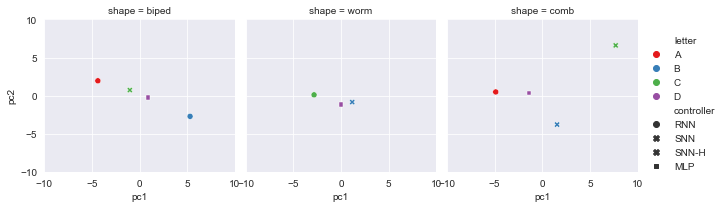

In [61]:
g = sns.FacetGrid(video_df, col="shape")
g.map_dataframe(sns.scatterplot, x="pc1", y="pc2", hue="letter", style="controller", palette="Set1")
g.set(xlim=(-10, 10), ylim=(-10, 10))
g.add_legend()
plt.show()